In [1]:
%matplotlib inline

In [36]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from harmonies import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

In [32]:
def quantize_img_twice(img_hls, preprocess=preprocess_img_hls, palette=cube_palette):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(preprocess(img_hls), palette, apply_sin_to_hue=True)
    
    return np.array(list(map(lambda x: inverse_map[x], palette_index_matrix.flatten()))).reshape(shape[0], shape[1], 3)

def get_rgb_quantize_img_twice(img_hls, preprocess=preprocess_img_hls, palette=cube_palette):
    quantized_img = quantize_img_twice(img_hls, preprocess, palette) * (180, 255, 255)
    
    plt.imshow(cv2.cvtColor(np.uint8(quantized_img), cv2.COLOR_HLS2RGB))
    plt.show()

# Paleta de Analisis

In [3]:
hue_steps = 12
hue_range = 360
hue_step_size = int(360/hue_steps)

hues = np.array([(hue_step/hue_range) for hue_step in range(0, hue_range, hue_step_size)])
example_hues = np.array([(hue_step, 0.5, 0.5) for hue_step in hues])


def get_hue_palette_cube(hues)
    luminances = np.array([0, 0.33, 0.66, 1])
    hue_luminance = np.transpose([np.tile(hues, len(luminances)), np.repeat(luminances, len(hues))]).copy()
    saturations = np.array([0, 0.33, 0.66, 1])

    hls_stack = []
    for saturation in saturations:
        hls_array_proto = np.zeros((hue_luminance.shape[0], hue_luminance.shape[1] + 1))
        hls_array_proto[:, :2] = hue_luminance.copy()

        hls_array_proto[:, 2] = saturation
        hls_stack.append(hls_array_proto)

    cube = np.stack(hls_stack).reshape(-1,3)
    
    pd_cube = pd.DataFrame(cube, columns=['hue', 'luminance', 'saturation'])
    pd_cube = pd_cube.sort_values(by=['hue','luminance','saturation']).reset_index(drop=True)
    pd_cube = pd_cube.reset_index()

    final_cube = pd_cube[['hue','luminance','saturation']].values.reshape(len(hues), len(luminances), len(saturations), 3)
    cube_palette = final_cube.reshape(-1, 3)
    cube_indices = np.array(list(range(len(cube_palette))))
    
    pd_cube['blanco'] = 1*(pd_cube['luminance'] == 1)
    pd_cube['negro'] = 1*(pd_cube['luminance'] == 0)
    pd_cube['gris'] = 1*(pd_cube['saturation'] == 0)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])
    
    for idx, hue in enumerate(hues):
        pd_cube['hue_%s' % idx] = 1*(pd_cube['hue'] == hue)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])*(1-pd_cube['gris'])
    
    blancos = list(pd_cube[pd_cube['blanco'] == 1]['index'].values)
    negros = list(pd_cube[pd_cube['negro'] == 1]['index'].values)
    gris = list(pd_cube[pd_cube['gris'] == 1]['index'].values)
    
    final_analysis_array = [
        ('negros', negros, (0, 0, 0))
        ,('grises', gris, (0, 0.5, 0))
        ,('blancos', blancos, (0, 0.85, 0))
    ] + [
        (
            'hue_%s' % hue_idx,
            list(pd_cube[pd_cube['hue_%s' % hue_idx] == 1]['index'].values), 
            example_hues[hue_idx]
        )
        for hue_idx in range(len(hues))
    ]

    final_analysis_names = [i[0] for i in final_analysis_array]
    final_analysis_palette = np.array([i[2] for i in final_analysis_array])

    inverse_map = {}
    for name, codes, color in final_analysis_array:
        for code in codes:
            inverse_map[code] = color
            
    return inverse_map

In [4]:
pd_cube = pd.DataFrame(cube, columns=['hue', 'luminance', 'saturation'])
pd_cube = pd_cube.sort_values(by=['hue','luminance','saturation']).reset_index(drop=True)
pd_cube = pd_cube.reset_index()

final_cube = pd_cube[['hue','luminance','saturation']].values.reshape(len(hues), len(luminances), len(saturations), 3)
cube_palette = final_cube.reshape(-1, 3)
cube_indices = np.array(list(range(len(cube_palette))))

In [5]:
pd_cube['blanco'] = 1*(pd_cube['luminance'] == 1)
pd_cube['negro'] = 1*(pd_cube['luminance'] == 0)
pd_cube['gris'] = 1*(pd_cube['saturation'] == 0)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])

In [6]:
for idx, hue in enumerate(hues):
    pd_cube['hue_%s' % idx] = 1*(pd_cube['hue'] == hue)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])*(1-pd_cube['gris'])

In [7]:
blancos = list(pd_cube[pd_cube['blanco'] == 1]['index'].values)
negros = list(pd_cube[pd_cube['negro'] == 1]['index'].values)
gris = list(pd_cube[pd_cube['gris'] == 1]['index'].values)

In [34]:
final_analysis_array = [
    ('negros', negros, (0, 0, 0))
    ,('grises', gris, (0, 0.5, 0))
    ,('blancos', blancos, (0, 0.85, 0))
] + [
    (
        'hue_%s' % hue_idx,
        list(pd_cube[pd_cube['hue_%s' % hue_idx] == 1]['index'].values), 
        example_hues[hue_idx]
    )
    for hue_idx in range(len(hues))
]

final_analysis_names = [i[0] for i in final_analysis_array]
final_analysis_palette = np.array([i[2] for i in final_analysis_array])

inverse_map = {}
for name, codes, color in final_analysis_array:
    for code in codes:
        inverse_map[code] = color

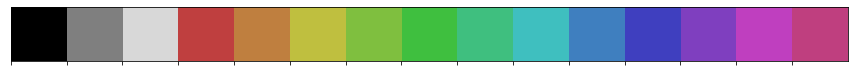

In [9]:
sns.palplot(get_palette(final_analysis_palette))

# Carga archivos

In [10]:
cam = glob.glob('../../../Osintgram/output/*.jpg')

In [11]:
def get_image_signature(img_path, preprocess=preprocess_img_hls, analysis_palette=np_itten_color_wheel, apply_sin_to_hue=True):
    img_rgb, img_hls = get_img(img_path)

    quantized_img = get_color_wheel_quantized_img(preprocess(img_hls), color_wheel=analysis_palette, apply_sin_to_hue=apply_sin_to_hue)
    signature = dict(zip(*np.unique(quantized_img, return_counts=True)))

    return signature

def get_image_signatures(img_list, preprocess=preprocess_img_hls, analysis_palette=np_itten_color_wheel, apply_sin_to_hue=True):
    signatures = []
    
    results = joblib.Parallel(n_jobs=12)(joblib.delayed(get_image_signature)(img_path, analysis_palette=analysis_palette, apply_sin_to_hue=apply_sin_to_hue) for img_path in tqdm(img_list))
            
    return results

In [12]:
signatures = get_image_signatures(cam, analysis_palette=cube_palette)

100%|██████████| 1537/1537 [05:04<00:00,  5.04it/s]


In [13]:
pd_signatures = pd.DataFrame(signatures).fillna(0)

In [14]:
for name, indices, _ in final_analysis_array:
    pd_signatures[name] = pd_signatures[indices].sum(axis=1)

In [25]:
pd_discretized_signature = pd_signatures[final_analysis_names[3:]]
pd_discretized_total_signature = pd_signatures[final_analysis_names]

In [26]:
pd_discr_weighted_signatures = pd_discretized_signature.apply(lambda x: x/x.sum(), axis=1).fillna(0)
pd_discr_weighted_total_signatures = pd_discretized_total_signature.apply(lambda x: x/x.sum(), axis=1)

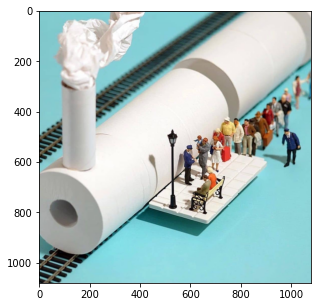

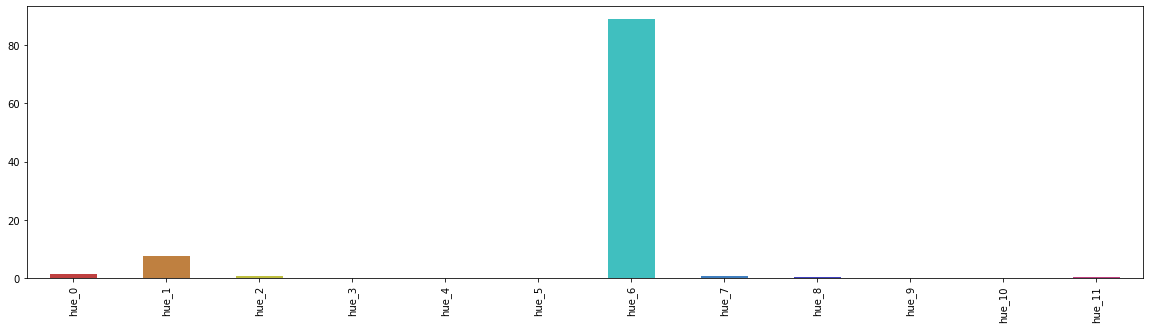

hue_0      1.327218
hue_1      7.682616
hue_2      0.620462
hue_3      0.010624
hue_4      0.003541
hue_5      0.169979
hue_6     88.862444
hue_7      0.648046
hue_8      0.414511
hue_9      0.012301
hue_10     0.000559
hue_11     0.247700
Name: 141, dtype: float64


In [30]:
img_idx = 141

plt.imshow(get_img(cam[img_idx])[0])
plt.show()

(pd_discr_weighted_signatures.iloc[img_idx]*100).plot.bar(color=get_palette(final_analysis_palette[3:]))
plt.show()
print((pd_discr_weighted_signatures.iloc[img_idx]*100))

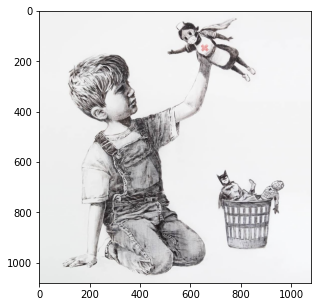

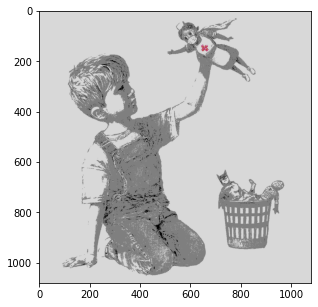

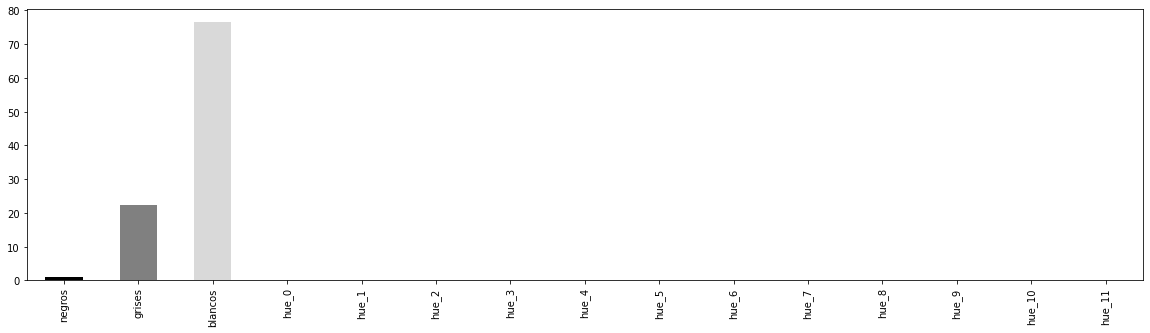

hue_0     51.345756
hue_1      0.000000
hue_2      0.000000
hue_3      0.000000
hue_4      0.000000
hue_5      0.000000
hue_6      0.000000
hue_7      0.000000
hue_8      0.000000
hue_9      0.000000
hue_10     0.000000
hue_11    48.654244
Name: 46, dtype: float64


In [41]:
img_idx = 46
#img_idx = 11
#img_idx = 46

plt.imshow(get_img(cam[img_idx])[0])
plt.show()

get_rgb_quantize_img_twice(get_img(cam[img_idx])[1])
plt.show()

(pd_discr_weighted_total_signatures.iloc[img_idx]*100).plot.bar(color=get_palette(final_analysis_palette))
plt.show()
print((pd_discr_weighted_signatures.iloc[img_idx]*100))

<AxesSubplot:>

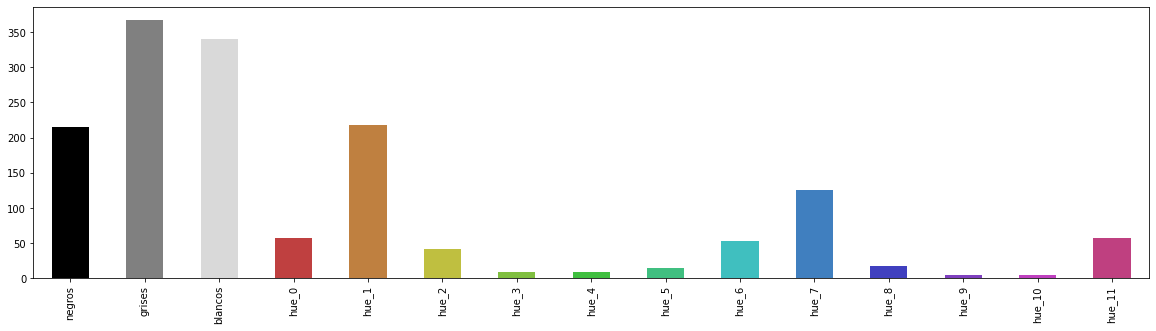

In [18]:
pd_discr_weighted_signatures.sum().plot.bar(color=get_palette(final_analysis_palette))

<AxesSubplot:>

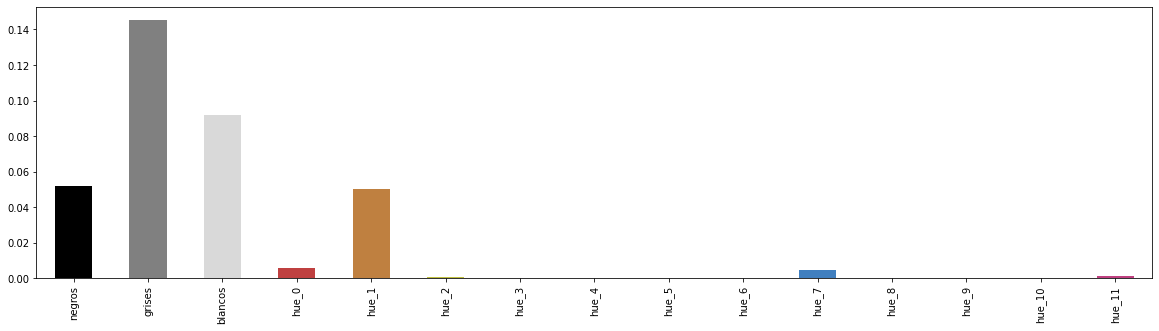

In [19]:
pd_discr_weighted_signatures.median().plot.bar(color=get_palette(final_analysis_palette))

In [19]:
pd_weighted_signatures = pd_signatures.apply(lambda x: x/x.sum(), axis=1)

# Otros

In [37]:
check_relaciones = pd_discr_weighted_signatures.copy()

check_relaciones['monochromatic'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(monochromatic, axis=1)
check_relaciones['analogous'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(analogous, axis=1)
check_relaciones['complementary'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(complementary, axis=1)
check_relaciones['splitComplementary'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(splitComplementary, axis=1)
check_relaciones['triad'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(triad, axis=1)
check_relaciones['square'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(square, axis=1)
check_relaciones['rectangular'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(rectangular, axis=1)


<AxesSubplot:>

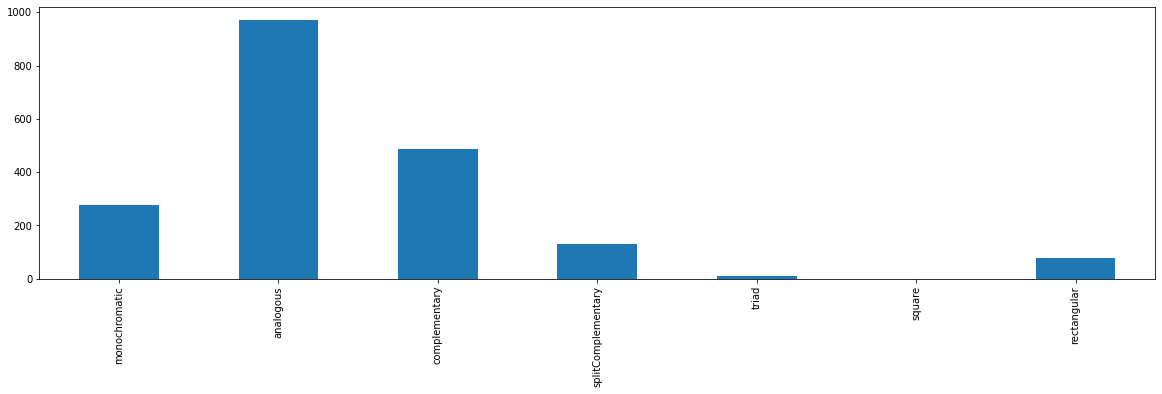

In [38]:
check_relaciones[['monochromatic','analogous','complementary','splitComplementary','triad','square','rectangular']].sum().plot.bar()

# Pruebas Luminancia y posicion

In [23]:
def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

In [342]:
img = cam[0]
img_rgb, img_hls = get_img(img)

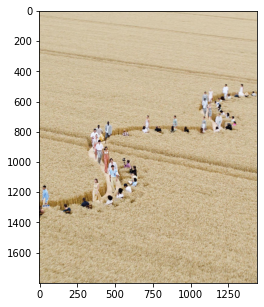

In [345]:
plt.imshow(img_rgb)

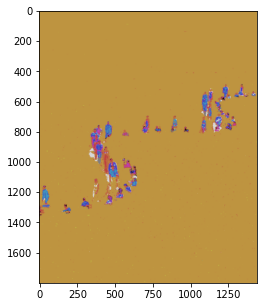

In [348]:
quantized_img = quantize_img_color_wheel(preprocess_img_hls(img_hls), cube_palette)
itten_quantized_img = quantize_img_color_wheel(quantized_img, final_analysis_palette)
plt.imshow(cv2.cvtColor(np.uint8(itten_quantized_img * (180, 255, 255)), cv2.COLOR_HLS2RGB))

In [347]:
quantized_img

array([[[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        ...,
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ]],

       [[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        ...,
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ]],

       [[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        ...,
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ]],

       ...,

       [[0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0.66      , 0.33      ],
        [0.11111111, 0

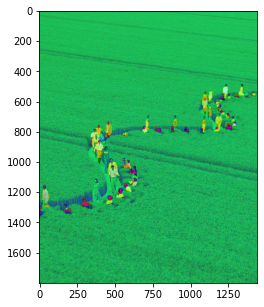

In [343]:
plt.imshow(preprocess_img_hls(img_hls), cmap='gray')